In [1]:
from gensim.models.ldamodel import LdaModel
import gensim
import pandas as pd
import glob
from nltk.corpus import stopwords
import string
from gensim import corpora,models
from gensim.utils import lemmatize # Only keep nums
from gensim.corpora import Dictionary
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
import sys
import numpy as np
import enchant

C:\Users\mnan\Anaconda3\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\mnan\Anaconda3\lib\site-packages\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
def process_text(content_list):
    """
    stopwords
    
    punctuation
    
    digits
    
    english words
    
    """
    typical_words = ['light','therapy','facial','skin','rt','treatment']
    stoplist = stopwords.words('english') + typical_words 
    
    remove_digits = str.maketrans('', '', string.digits)
    remove_punctuation = str.maketrans('', '', string.punctuation)
    
    dict_english = enchant.Dict("en_US")
    
    lemma = WordNetLemmatizer()
    
    content_cleaned =[i.translate(remove_digits) for i in content_list]
    
    content_cleaned = [i.translate(remove_punctuation) for i in content_cleaned]
    
    content_cleaned = [[lemma.lemmatize(word.lower()) for word in line.split()
                        if (word.lower() not in stoplist) and dict_english.check(word.lower())==True] for line in content_cleaned]

    return content_cleaned

In [3]:
content = pd.read_csv('text.csv',encoding = 'iso-8859-1',header=None)
content.columns = ['content']
content['content']
print(len(content))
content_list = content['content'].values
cleaned_list = process_text(content_list)
print('after process....')
print(len(cleaned_list))

8001
after process....
8001


Reviews with no extracted value

In [4]:
len(list(filter(lambda x:x==[],cleaned_list)))

62

** Build Dict **

In [5]:
dictionary = Dictionary(cleaned_list)
corpus = [dictionary.doc2bow(text) for text in cleaned_list]

In [6]:
num_topics = 10
lda = LdaModel(corpus, num_topics= num_topics,id2word = dictionary)
lda.show_topics(num_topics,15)

[(0,
  '0.096*"technology" + 0.096*"energy" + 0.096*"winter" + 0.095*"stop" + 0.095*"news" + 0.095*"brighten" + 0.095*"bus" + 0.095*"panel" + 0.095*"environment" + 0.003*"psoriasis" + 0.003*"used" + 0.003*"new" + 0.003*"condition" + 0.003*"acne" + 0.002*"treat"'),
 (1,
  '0.021*"like" + 0.021*"look" + 0.010*"natural" + 0.009*"red" + 0.009*"right" + 0.009*"kind" + 0.009*"skin" + 0.008*"pub" + 0.008*"beauty" + 0.008*"bring" + 0.007*"led" + 0.007*"take" + 0.007*"much" + 0.006*"baby" + 0.006*"treat"'),
 (2,
  '0.024*"skincare" + 0.020*"led" + 0.016*"issue" + 0.013*"today" + 0.012*"dermatology" + 0.012*"work" + 0.010*"video" + 0.009*"here" + 0.009*"industry" + 0.009*"hot" + 0.008*"stuff" + 0.007*"watch" + 0.007*"solution" + 0.007*"study" + 0.006*"benefit"'),
 (3,
  '0.016*"cause" + 0.015*"red" + 0.013*"light" + 0.012*"acne" + 0.012*"cell" + 0.012*"photo" + 0.011*"mask" + 0.011*"thank" + 0.010*"wavelength" + 0.010*"relief" + 0.010*"care" + 0.009*"unforgiving" + 0.009*"goodness" + 0.009*"led"

In [7]:
assign = []
for i in range(len(corpus)):
    assign.append(sorted(lda[corpus[i]],key = lambda x:x[1],reverse = True)[0][0])
conf_score = []
for i in range(len(corpus)):
    conf_score.append(sorted(lda[corpus[i]],key = lambda x:x[1],reverse = True)[0][1])

In [8]:
df_bow = pd.DataFrame({'original_text':content.content.values,
             'corpus':corpus,
            'assign':assign,
            'conf_score':conf_score,
                      'bow':cleaned_list})

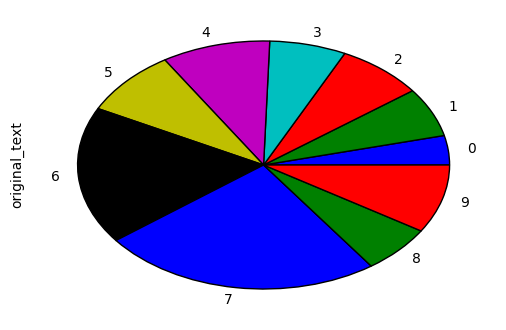

In [9]:
df_bow.groupby('assign').count()['original_text'].plot(kind='pie')

** 7 category is likely to be ads (many general and descriptive words related to promotion, let's see. **

In [18]:
for i in df_bow[df_bow['assign']==7]['original_text'].sample(15):
    print(i+'\n')

RT @olivia_holt: Glam complete for an exciting day launching the @Neutrogena light therapy mask! #MaskYoself pic.twitter.com/5RZ6bBb7lV

RT @vBBlogDirectory: How blue light therapy can help to prevent #acne su.pr/33iIih

RT @Theralight: Skincare Benefits of Violet Light Therapy su.pr/2LYKgX

RT @olivia_holt: Celebrating #TreatYoSelfDay with the my new fav @neutrogena light therapy mask. How ya?ll treatin' yoself? #MaskYoSelf #NTGSpokesperson pic.twitter.com/NYJz4wDg2I

Trophy Skin RejuveliteMD High Power Red Light Therapy Anti-Aging LED Treatment fb.me/7OH4uBbSC

XL BLUE 465nm Acne Healing LED Light Therapy. PhotoTherapy. At-home device toys-and-hobbies.info/tysnd/hbbs014/? pic.twitter.com/7SlWFJhDTC

New from @RomyRaves #MaskYoSelf with Neutrogena?s New Light Therapy Acne Mask: I'm excited to be among the fi... tinyurl.com/zxhhnfy

Blue Light Therapy, Light and Heat Energy Therapy, Laser Light Therapy bit.ly/scalpfolliculi? Acne Pimples

#SkincareBenefits of Violet Light Therapy soma3

** Looks like most of them are actually are ads!!! **

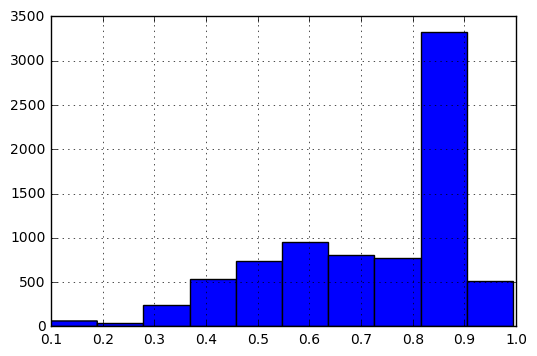

In [10]:
df_bow['conf_score'].hist()

In [11]:
df_bow[df_bow['conf_score']<0.5][['bow','original_text']]

,bow,original_text
3,"[may, face, lotion, lite, review, two, favorit...","Sunday, May 1, 2016\n\nGlyDerm Face Lotion Lit..."
8,"[reverse, pigmentation]",RT @annawinek: How Does Light Therapy Reverse ...
25,"[present, doc, peel, wonderful, experience]","#DmvNetworks presents\n\nDC Derm Docs\nBotox, ..."
29,"[acne, experience]",Acne Light Therapy Treatment Experience people...
33,"[care, time, master, device, led]",NORLANYA Facial Care Time Master Device with L...
35,"[beauty, angel, type, red, supposed, help, cle...",The Beauty Angel is a type of Red Light Therap...
39,"[system, w, case, swiss, cosmetic, care, wound...",BIOPTRON 1 Light Therapy System W/ Case Swiss ...
49,"[take, control, skincare]",Take control of your #rosacea with an #IPL #Ph...
54,"[revive, acne, head, revive, interchangeable, ...",WHAT IT IS: Revive Acne Treatment Head. ReVive...
61,"[get, using, power, center, home, bitter, deve...",Get a facial using the power of light!\nEpi Ce...


Now we try to use TFIDF

In [19]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
num_topics = 10
lda_tfidf = LdaModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)
lda.show_topics(num_topics,15)

[(0,
  '0.026*"led" + 0.018*"cause" + 0.014*"red" + 0.014*"device" + 0.011*"beauty" + 0.011*"cell" + 0.010*"acne" + 0.010*"wavelength" + 0.009*"layer" + 0.009*"create" + 0.008*"healthier" + 0.008*"regenerate" + 0.008*"laser" + 0.007*"newer" + 0.006*"like"'),
 (1,
  '0.040*"skincare" + 0.035*"anti" + 0.027*"care" + 0.022*"acne" + 0.021*"aging" + 0.019*"led" + 0.018*"min" + 0.017*"natural" + 0.014*"system" + 0.014*"remedy" + 0.014*"revive" + 0.010*"step" + 0.010*"car" + 0.010*"improves" + 0.009*"spa"'),
 (2,
  '0.069*"led" + 0.053*"skincare" + 0.033*"violet" + 0.032*"machine" + 0.027*"ultrasound" + 0.026*"benefit" + 0.025*"photon" + 0.025*"care" + 0.023*"system" + 0.022*"intensity" + 0.021*"beauty" + 0.021*"ultrasonic" + 0.019*"think" + 0.018*"wrinkle" + 0.017*"mask"'),
 (3,
  '0.095*"energy" + 0.095*"technology" + 0.094*"winter" + 0.094*"stop" + 0.094*"news" + 0.094*"brighten" + 0.094*"panel" + 0.094*"environment" + 0.094*"bus" + 0.004*"psoriasis" + 0.004*"used" + 0.003*"condition" + 0.

In [20]:
assign = []
for i in range(len(corpus_tfidf)):
    assign.append(sorted(lda_tfidf[corpus_tfidf[i]],key = lambda x:x[1],reverse = True)[0][0])
conf_score = []
for i in range(len(corpus_tfidf)):
    conf_score.append(sorted(lda[corpus_tfidf[i]],key = lambda x:x[1],reverse = True)[0][1])

In [21]:
df_tfidf = pd.DataFrame({'original_text':content.content.values,
             'corpus':corpus,
            'assign':assign,
            'conf_score':conf_score,
                      'bow':cleaned_list})

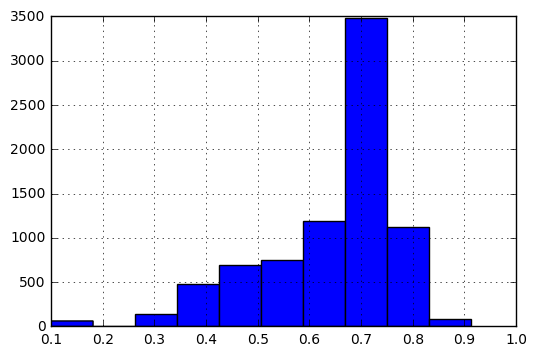

In [22]:
df_tfidf['conf_score'].hist()

In [23]:
df_tfidf[df_tfidf['conf_score']<0.5][['bow','original_text']]

,bow,original_text
2,"[spotted, new, favorite, beauty, acne, mask]",@Star_news spotted @Olivia_Holt with her new f...
3,"[may, face, lotion, lite, review, two, favorit...","Sunday, May 1, 2016\n\nGlyDerm Face Lotion Lit..."
25,"[present, doc, peel, wonderful, experience]","#DmvNetworks presents\n\nDC Derm Docs\nBotox, ..."
31,"[skincare, issue, care]",have any #skincare issues? #olivegold03 and li...
48,"[health, acne, new, blue, color, skincare, acn...",RT @WXU_DEZ_025: #Health #Acne sherif.ws/acne/...
49,"[take, control, skincare]",Take control of your #rosacea with an #IPL #Ph...
53,"[color, led, light, photon, rejuvenation, lift...",4 Colors Led Light Therapy Lights Photon Rejuv...
63,"[improves, appearance, application]",RT @Theralight: #Photorejuvenation improves th...
83,"[interested, red, read, skincare]",Interested in having a Red Light Therapy?\nRea...
89,"[opera, led, mask, action, orchid, spa, wellne...",This is the OPERA LED facial mask in action at...


In [24]:
import nltk
import itertools
from collections import Counter
import operator

In [25]:
corpus_with_pos = list(map(lambda x:nltk.pos_tag(x),cleaned_list))

In [26]:
sorted(dict(Counter(list(map(lambda x: x[1],sum(corpus_with_pos,[]))))).items(),key=operator.itemgetter(1),reverse = True)

[('NN', 46353),
 ('JJ', 16991),
 ('VBD', 4707),
 ('VBG', 4108),
 ('RB', 3319),
 ('VBN', 2654),
 ('VB', 2081),
 ('VBP', 1519),
 ('NNS', 1293),
 ('IN', 1263),
 ('CD', 533),
 ('VBZ', 470),
 ('JJR', 457),
 ('MD', 420),
 ('JJS', 332),
 ('FW', 175),
 ('RBR', 147),
 ('CC', 139),
 ('PRP', 137),
 ('DT', 99),
 ('NNP', 71),
 ('RBS', 39),
 ('RP', 36),
 ('WP', 33),
 ('WRB', 18),
 ('SYM', 12),
 ('UH', 8),
 ('EX', 6),
 ('WDT', 4),
 ('WP$', 2),
 ('PRP$', 1)]

C:\Users\mnan\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


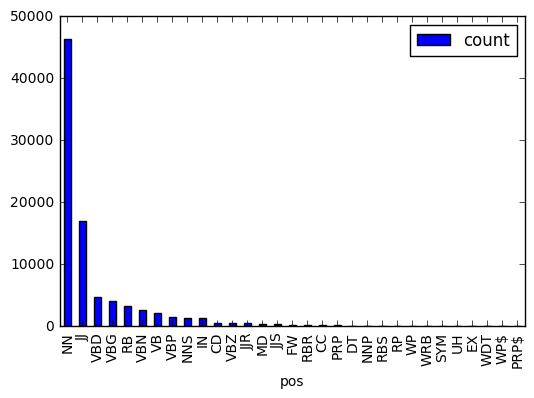

In [27]:
count_pos_dict = dict(Counter(list(map(lambda x: x[1],sum(corpus_with_pos,[])))))
pd.DataFrame({'count':list(count_pos_dict.values()),'pos':list(count_pos_dict.keys())}).set_index('pos').sort('count',ascending=False).plot(kind = 'bar')

In [28]:
keep_pos = ['JJ','JJS','JJR','NN','NNP','RB','VB','VBP','VBZ','RBR','VBD','VBN']

In [29]:
list(filter(lambda x: x[0] in keep_pos,dict(Counter(list(map(lambda x: x[1],sum(corpus_with_pos,[]))))).items()))

[('VBZ', 470),
 ('VBP', 1519),
 ('VBD', 4707),
 ('JJ', 16991),
 ('NNP', 71),
 ('JJR', 457),
 ('NN', 46353),
 ('JJS', 332),
 ('VBN', 2654),
 ('RBR', 147),
 ('RB', 3319),
 ('VB', 2081)]

In [30]:
filtered_corpus_with_pos=[]
for i in corpus_with_pos:
    filtered_corpus_with_pos.append(list(filter(lambda x: x[1] in keep_pos,i)))

In [31]:
filtered_corpus_by_pos = []
for i in filtered_corpus_with_pos:
    filtered_corpus_by_pos.append(list(map(lambda x: x[0],i)))

In [32]:
dictionary_pos = Dictionary(filtered_corpus_by_pos)
corpus_pos = [dictionary_pos.doc2bow(text) for text in filtered_corpus_by_pos]

In [33]:
tfidf_by_pos = models.TfidfModel(corpus_pos)
corpus_by_pos_tfidf = tfidf_by_pos[corpus_pos]
num_topics = 10
lda_pos_tfidf = LdaModel(corpus_by_pos_tfidf, id2word=dictionary_pos, num_topics=num_topics)
lda_pos_tfidf.show_topics(num_topics,10)

[(0,
  '0.016*"downtime" + 0.015*"needle" + 0.015*"estimated" + 0.015*"affect" + 0.013*"pain" + 0.009*"beauty" + 0.009*"led" + 0.009*"acne" + 0.008*"collagen" + 0.008*"rejuvenation"'),
 (1,
  '0.049*"blue" + 0.048*"acne" + 0.030*"red" + 0.025*"sun" + 0.019*"healing" + 0.019*"prevent" + 0.019*"new" + 0.018*"help" + 0.015*"led" + 0.014*"matter"'),
 (2,
  '0.025*"violet" + 0.023*"psoriasis" + 0.022*"min" + 0.020*"condition" + 0.020*"used" + 0.019*"treat" + 0.018*"serious" + 0.017*"acne" + 0.012*"system" + 0.012*"car"'),
 (3,
  '0.039*"photon" + 0.036*"mask" + 0.034*"led" + 0.032*"rejuvenation" + 0.027*"beauty" + 0.027*"ultrasonic" + 0.022*"wrinkle" + 0.022*"complete" + 0.021*"color" + 0.020*"ultrasound"'),
 (4,
  '0.020*"solution" + 0.018*"cause" + 0.015*"issue" + 0.012*"get" + 0.011*"kind" + 0.011*"bring" + 0.011*"natural" + 0.011*"wavelength" + 0.011*"skin" + 0.010*"healthier"'),
 (5,
  '0.042*"look" + 0.012*"treat" + 0.011*"age" + 0.011*"perfect" + 0.010*"love" + 0.010*"wish" + 0.010*"

In [118]:
bigram = gensim.models.Phrases(cleaned_list,min_count=1, threshold=2)
dictionary_text_list = list(bigram[cleaned_list])
train_text_list = list(bigram[cleaned_list])
dictionary_bigram = Dictionary(dictionary_text_list)
corpus_bigram = [dictionary_bigram.doc2bow(text) for text in train_text_list]

C:\Users\mnan\Anaconda3\lib\site-packages\gensim\models\phrases.py:248: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [119]:
num_topics = 10
lda_tfidf = LdaModel(corpus_bigram, id2word=dictionary_bigram, num_topics=num_topics)
lda.show_topics(num_topics,15)

[(0,
  '0.027*"violet" + 0.016*"benefit" + 0.015*"skin" + 0.010*"help" + 0.008*"low" + 0.007*"time" + 0.007*"black" + 0.007*"level" + 0.006*"red" + 0.005*"body" + 0.005*"muscle" + 0.005*"one" + 0.005*"mask" + 0.005*"led" + 0.004*"tone"'),
 (1,
  '0.056*"led" + 0.052*"skin" + 0.030*"wrinkle" + 0.026*"acne" + 0.015*"care" + 0.012*"ultrasound" + 0.012*"ultrasonic" + 0.012*"blue" + 0.011*"high" + 0.011*"red" + 0.010*"intensity" + 0.009*"machine" + 0.009*"focused" + 0.009*"collagen" + 0.008*"rt"'),
 (2,
  '0.019*"day" + 0.017*"new" + 0.017*"mask" + 0.014*"device" + 0.013*"rt" + 0.013*"exciting" + 0.013*"complete" + 0.012*"launching" + 0.011*"added" + 0.007*"medical" + 0.007*"led" + 0.007*"pub" + 0.005*"acne" + 0.005*"patient" + 0.005*"health"'),
 (3,
  '0.099*"led" + 0.061*"mask" + 0.056*"skin" + 0.048*"acne" + 0.042*"beauty" + 0.040*"photon" + 0.040*"rejuvenation" + 0.035*"new" + 0.028*"color" + 0.026*"blue" + 0.025*"red" + 0.018*"care" + 0.016*"sun" + 0.014*"face" + 0.012*"healing"'),
 (4

** Look Bad **

# Conclusion:

#### Bag of Words is the best